In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import re
import os
from PIL import Image
import cv2
import requests
from io import BytesIO
from joblib import Parallel, delayed

from glob import glob
from tqdm import tqdm

from itertools import chain
from collections import Counter
from matplotlib import pyplot as plt

In [3]:
import sys

sys.path.append('..')
from src.configs import config
%load_ext autoreload
%autoreload 2

In [ ]:
#from https://www.proteinatlas.org/download/subcellular_location.tsv.zip
subcellular_location = pd.read_csv('../../subcellular_location.tsv', sep="\t",index_col = None)
subcellular_location.tail()

In [ ]:
#get xmls
for name in tqdm(subcellular_location.Gene.values):
    url = ('https://www.proteinatlas.org/{}.xml'.format(name))
    path = os.path.join(config.PATHS['XML'], name + '.xml')
    
    response = requests.get(url)
    fd = open(path, mode='w')
    fd.write(response.text)
    fd.close()

# Process XMLs

In [4]:
import xml.etree.ElementTree as ET

In [ ]:
pattern = os.path.join(config.PATHS['XML'], '*.xml')
columns = ['verification', 'url', 'labels', 'xml_id']
df = pd.DataFrame(columns=columns)

for path in tqdm(glob(pattern)):
    xml_id = os.path.basename(path)[:-4]
    parsed = ET.parse(path)
    root = parsed.getroot()

    raws = list()
    subAssay = root.findall('entry/antibody/cellExpression/subAssay')
    for sub in subAssay:
        verification = sub.find('verification')
        if verification is None:
            continue
        verification = verification.text

        for data in sub.findall('data'):
            labels = [location.text for location in data.findall('location')]
            labels = '|'.join(labels)
            urls = [imageUrl.text for imageUrl in data.findall('./assayImage/image/imageUrl')]
            for url in urls:
                raws.append((verification, url, labels, xml_id))

    patch = pd.DataFrame(raws, columns=columns)    
    df = df.append(patch)
    df.reset_index(drop=True, inplace=True)


In [5]:
csv_path = os.path.join(config.PATHS['CSV'], 'external_full.csv')
# df.url = df.url.apply(lambda x: '{}'.join(x.split('blue_red_green')))
# df.to_csv(csv_path, index=False)
# df.verification.value_counts()
# df.url.apply(lambda x: os.path.join(os.path.basename(os.path.dirname(x)), os.path.basename(x))).unique()

In [6]:
df = pd.read_csv(csv_path)
df.head()

,verification,url,labels,xml_id
0,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884
1,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884
2,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884
3,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884
4,enhanced,http://v18.proteinatlas.org/images/49886/884_H...,cytosol,ENSG00000168884


In [7]:
def extract_yellow(url, colours=['yellow'], shape=config.PARAMS['SHRINKED_FULL_SIZE']):
    shape = (shape, shape)
    shapes = list()

    for colour in colours:
        link = url.format(colour)
        name = '_'.join([os.path.basename(os.path.dirname(link)), os.path.basename(link)])
        name = '.'.join(name.split('.')[:-1] + ['png'])
        path = os.path.join(config.PATHS['TRAIN'], name)
        if os.path.isfile(path):
            continue

        response = requests.get(link)
        img = Image.open(BytesIO(response.content))
        img = np.array(img)

        if colour != 'blue_red_green':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[..., -1]

        assert img.shape[0] == img.shape[1]
        shapes.append((url, img.shape))

        img = cv2.resize(img, shape, cv2.INTER_AREA)
        cv2.imwrite(path, img)

    return shapes

In [8]:
def extract_brg(url, root_dir='../data/external_masks/', colours=['red', 'green', 'blue'], shape=config.PARAMS['SHRINKED_FULL_SIZE']):
    shape = (shape, shape)

    link = url.format('blue_red_green')
    name = '_'.join([os.path.basename(os.path.dirname(link)), os.path.basename(link)])
    name = '.'.join(name.split('.')[:-1] + ['png'])
    path = os.path.join(root_dir, name)

    if os.path.isfile(path):
        return

    imgs = list()
    for colour in colours:
        for i in range(10000):
            try:
                link = url.format(colour)

                response = requests.get(link)
                img = Image.open(BytesIO(response.content))
                img = np.array(img)

                img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[..., -1]

                assert img.shape[0] == img.shape[1]

                imgs.append(cv2.resize(img, shape, cv2.INTER_AREA))
                break
            except:
                pass

    assert len(imgs) == 3
    imgs = np.dstack(imgs)
    cv2.imwrite(path, imgs)
    return url, img.shape

In [9]:
def extract_masks(url, root_dir='../data/external_masks/', colour='segmentation', shape=config.PARAMS['SHRINKED_FULL_SIZE']):
    shape = (shape, shape)

    link = url.format('mask')
    name = '_'.join([os.path.basename(os.path.dirname(link)), os.path.basename(link)])
    name = '.'.join(name.split('.')[:-1] + ['png'])
    path = os.path.join(root_dir, name)

    if os.path.isfile(path):
        return

    link = url.format(colour)
    for i in range(10000):
        try:
            response = requests.get(link, timeout=None)
            img = Image.open(BytesIO(response.content))
            img = np.array(img)

            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[..., -1]

            assert img.shape[0] == img.shape[1]

            img = cv2.resize(img, shape, cv2.INTER_AREA)
            cv2.imwrite(path, img)
            return url, img.shape
        except:
            pass
        return
        


In [10]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

In [ ]:
urls = df.url.apply(
    lambda x: x.replace('images', 'images_cell_segmentation').replace('.jpg', '.png')
)

nb = len(glob('../data/external_masks/*.png'))
print('Amount: {}'.format(nb))

shapes = [extract_masks(url) for url in tqdm(urls.values)]
# shapes = Parallel(n_jobs=24, prefer="threads")(delayed(extract_masks)(url) for url in tqdm(urls.values))

  0%|          | 0/85349 [00:00<?, ?it/s]

Amount: 0


  0%|          | 10/85349 [00:11<26:12:20,  1.11s/it]

In [11]:
nb = len(glob('../data/external_masks/*.png'))
print('Amount: {}'.format(nb))

shapes = Parallel(n_jobs=8, prefer="threads")(delayed(extract_brg)(url) for url in tqdm(df.url.values))

In [ ]:
urls = df.url.apply(
    lambda x: x.replace('images', 'images_cell_segmentation').replace('.jpg', '.png')
)

nb = len(glob('../data/external_masks/*.png'))
print('Amount: {}'.format(nb))

shapes = Parallel(n_jobs=24, prefer="threads")(delayed(extract_masks)(url) for url in tqdm(urls.values))

In [15]:
import scipy.ndimage

In [67]:
template = '../data/external_masks/*_mask.png'

# corrupted = list()
for path in tqdm(glob(template)):
    image = cv2.imread(path)[..., 0] > 0
    labels, colours = scipy.ndimage.label(image)
    roi = np.where(np.bincount(labels.flatten()) < 700)[0]
    dropped = np.isin(labels, roi)
    labels[dropped] = 0
    labels, colours = scipy.ndimage.label(labels > 0)
    labels.astype(np.uint16)
    cv2.imwrite(path, labels)


100%|██████████| 82156/82156 [12:06<00:00, 113.07it/s]


In [70]:
image = cv2.imread('../data/train_shrinked/17042_612_C6_4_blue_red_green.png', -1)

In [73]:
image = cv2.imread(path)[..., 0] > 0
labels, colours = scipy.ndimage.label(image)
roi = np.where(np.bincount(labels.flatten()) < 700)[0]
dropped = np.isin(labels, roi)


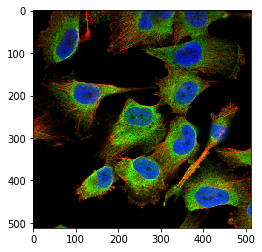

In [71]:
plt.imshow(image)

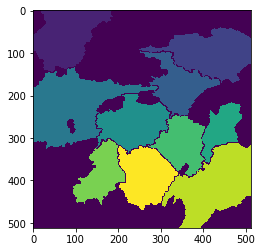

In [74]:
plt.imshow(labels)

In [ ]:
urls = df.url.apply(
    lambda x: x.replace('images', 'images_cell_segmentation').replace('.jpg', '.png')
)

shapes = list()
for url in tqdm(urls.values):
    shapes.append(extract_masks(url, root_dir='../data/external_masks/'))

### Check whether images corrupted

In [13]:
template = '../data/external_masks/*_blue_red_green.png'

corrupted = list()
for path in tqdm(glob(template)):
    image = cv2.imread(path)
    if not (image[..., 0] != image[..., 1]).sum():
        corrupted.append(path)

100%|██████████| 82162/82162 [09:26<00:00, 144.99it/s]


In [ ]:
url_template = 'https://v18.proteinatlas.org/images/{}/{}.jpg'

shapes = list()
for path in tqdm(corrupted):
    name = os.path.basename(path).split('_')
    image_sub_id = name[0]
    image_id = '.'.join('_'.join(name[1:]).split('.')[:-1])
    url = url_template.format(image_sub_id, image_id).replace('blue_red_green', '{}')
    shapes.append(extract_brg(url, shape=512))
print(url)

  4%|▍         | 157/3745 [08:39<3:17:42,  3.31s/it]

In [ ]:
shapes = list()
for url in tqdm(df.url.values):
    shapes.append(extract_data(url))

In [ ]:
shapes = list()
for url in tqdm(df.url.values):
    shapes.append(extract_data(url))

  0%|          | 185/85349 [00:44<5:44:12,  4.12it/s]

In [148]:
shapes = Parallel(n_jobs=12, prefer="threads")(delayed(extract_data)(url) for url in tqdm(df.url.values))

100%|██████████| 85349/85349 [00:44<00:00, 1915.40it/s]


In [124]:
im = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

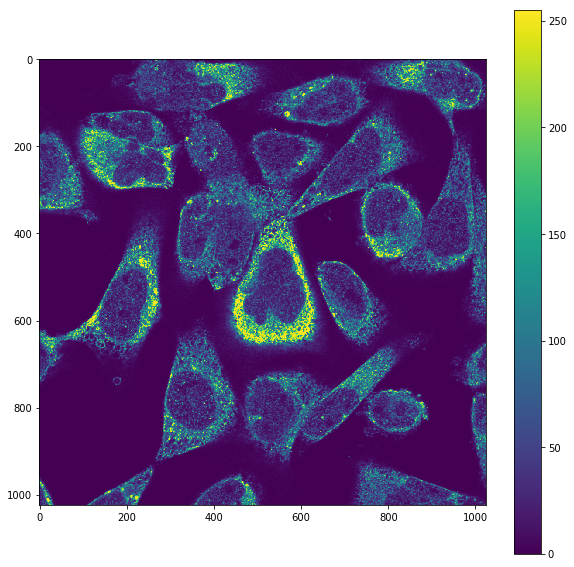

In [103]:
im = cv2.imread('../data/train_full_size/.png', 0)

plt.figure(figsize=(10, 10))
a = plt.imshow(im)
plt.colorbar(a)

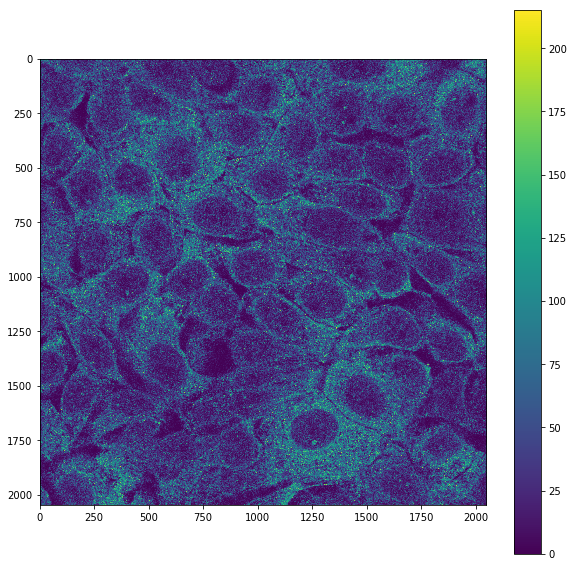

In [125]:
import cv2


plt.figure(figsize=(10, 10))
a = plt.imshow(im[..., 1])
plt.colorbar(a)

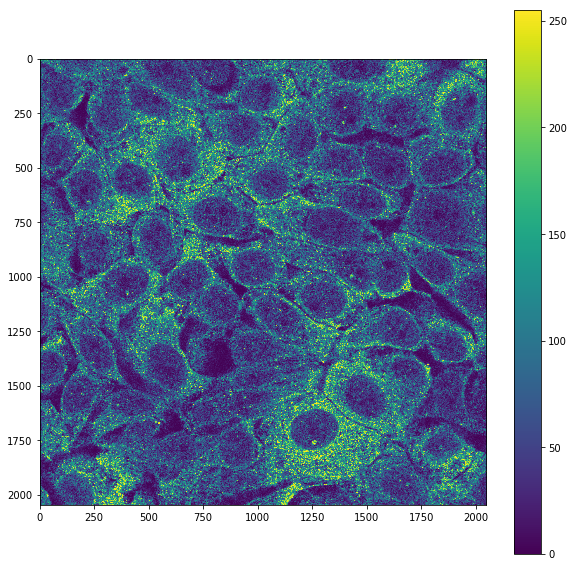

In [122]:
plt.figure(figsize=(10, 10))
a = plt.imshow(im[..., 2])
plt.colorbar(a)

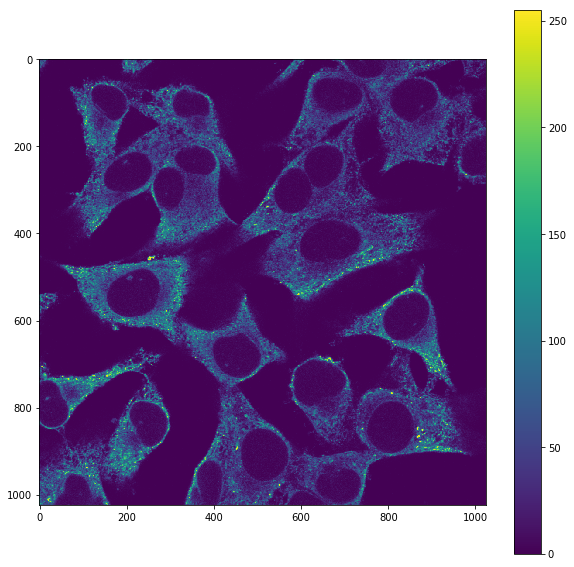

In [104]:
im = cv2.imread('../data/train_full_size/004efaa2-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png', 0)

plt.figure(figsize=(10, 10))
a = plt.imshow(im)
plt.colorbar(a)

In [15]:
subcellular_location.head()

,Gene,Gene name,Reliability,Enhanced,Supported,Approved,Uncertain,Single-cell variation intensity,Single-cell variation spatial,Cell cycle dependency,GO id
0,ENSG00000000003,TSPAN6,Approved,NaN,NaN,Cytosol,NaN,NaN,NaN,NaN,Cytosol (GO:0005829)
1,ENSG00000000457,SCYL3,Uncertain,NaN,NaN,NaN,Microtubules;Nuclear bodies,NaN,NaN,NaN,Microtubules (GO:0015630);Nuclear bodies (GO:0...
2,ENSG00000000460,C1orf112,Approved,NaN,NaN,Mitochondria,NaN,NaN,NaN,NaN,Mitochondria (GO:0005739)
3,ENSG00000000938,FGR,Approved,NaN,NaN,Aggresome;Plasma membrane,NaN,NaN,NaN,NaN,Aggresome (GO:0016235);Plasma membrane (GO:000...
4,ENSG00000000971,CFH,Approved,NaN,NaN,Vesicles,NaN,NaN,NaN,NaN,Vesicles (GO:0043231)


In [22]:
key = 'ENSG00000000971'
df.query('xml_id==@key')

,verification,url,labels,xml_id
13178,approved,http://v18.proteinatlas.org/images/38922/601_A...,vesicles,ENSG00000000971
13179,approved,http://v18.proteinatlas.org/images/38922/601_A...,vesicles,ENSG00000000971
13180,approved,http://v18.proteinatlas.org/images/38922/603_A...,NaN,ENSG00000000971
13181,approved,http://v18.proteinatlas.org/images/38922/603_A...,NaN,ENSG00000000971
13182,approved,http://v18.proteinatlas.org/images/38922/599_A...,vesicles,ENSG00000000971
13183,approved,http://v18.proteinatlas.org/images/38922/599_A...,vesicles,ENSG00000000971


In [218]:
colours = ['blue', 'green', 'red']
root_dir = '../data/external_data'

for path in tqdm(glob(os.path.join(root_dir, '*.png'))):
    name = os.path.basename(path)[:-4]
    image = cv2.imread(path)
    for i, el in enumerate(colours):
        save_path = os.path.join(root_dir, '{}_{}.{}'.format(name, el, 'png'))
        cv2.imwrite(save_path, image[..., i])


100%|██████████| 14230/14230 [18:08<00:00, 13.08it/s]


In [219]:
save_path

'../data/external_data/ENSG00000189060-H1F0_0_red.png'

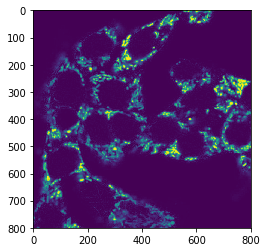

In [217]:
plt.imshow(image[..., 1])

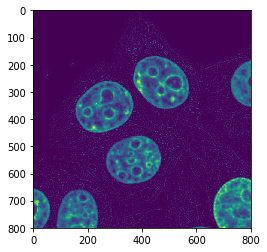

In [224]:
plt.imshow(cv2.imread('../data/external_data/ENSG00000001631-KRIT1_0_blue.png', 0))